# NCAR CESM High Resolution Ocean Simulation

In this notebook, we load and analyze data described in the following paper:

Small, R. J., et al. (2014), _A new synoptic scale resolving global climate simulation using the Community Earth System Model_, J. Adv. Model. Earth Syst., 6, 1065–1094.
<https://doi.org/10.1002/2014MS000363>

In [1]:
import xarray as xr
import numpy as np
import xgcm
import gcsfs
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (14,8)
%matplotlib inline

### Load High Resolution Ocean Surface Fields in Zarr Format

Catalog listing is at <https://pangeo-data.github.io/pangeo-datastore/master/ocean/cesm_pop.html>

In [25]:
ds = cat.CESM_POP_hires_RCP8_5(chunks=None).to_dask()
ds = ds.chunk({'time': 5})
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 16401, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTE                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTN                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3

In [26]:
ds.SSH_2.data

,Array,Chunk
Bytes,566.82 GB,172.80 MB
Shape,"(16401, 2400, 3600)","(5, 2400, 3600)"
Count,3282 Tasks,3281 Chunks
Type,float32,numpy.ndarray


In [27]:
mask = ds.SSH_2.isel(time=0).notnull()
ocean_area = (ds.TAREA.reset_coords(drop=True)
                     .where(mask)
                     .sum(dim=['nlon', 'nlat'])
                     .load().values.item())
ocean_area

3.607138039992101e+18

In [28]:
SSH_spatial_mean = (ds.SSH_2.reset_coords(drop=True) *
                    ds.TAREA.reset_coords(drop=True)).sum(dim=['nlon', 'nlat']) / ocean_area
SSH_spatial_mean

<xarray.DataArray (time: 16401)>
dask.array<truediv, shape=(16401,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2006-01-02 00:00:00 ... 2051-01-01 00:00:00

In [29]:
SSH_spatial_mean.data

,Array,Chunk
Bytes,131.21 kB,40 B
Shape,"(16401,)","(5,)"
Count,22972 Tasks,3281 Chunks
Type,float64,numpy.ndarray


In [30]:
SSH_spatial_mean.load()

<xarray.DataArray (time: 16401)>
array([0.00027946, 0.00027945, 0.00027947, ..., 0.00022861, 0.00022864,
       0.00022866])
Coordinates:
  * time     (time) object 2006-01-02 00:00:00 ... 2051-01-01 00:00:00

In [31]:
# throughput, GB/s
566 / (5.5*60)

1.715151515151515

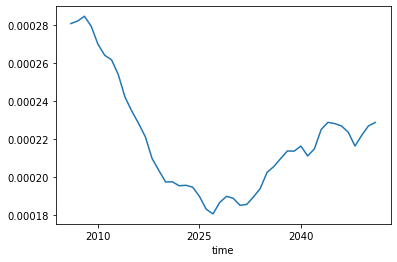

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1284, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1013, in _reconnect
    await self._close()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1284, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures

In [32]:
SSH_spatial_mean_ann_mean = SSH_spatial_mean.resample(time='AS').mean()
SSH_spatial_mean_ann_mean.plot()

In [18]:
from dask.distributed import Client

client = Client("tcp://10.32.78.25:46783")
client

Client Scheduler: tcp://10.32.78.25:46783 Dashboard: /user/0000-0001-5999-4917/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


### Transform POP Model Dimensions

The POP models uses the same dimensions (`nlat`, `nlon`) to describe all data variables,
despite the fact that these variables live at different points on the grid cell (T point vs. U point).
The true positions of the variables are encoded in the attribute `grid_loc`:

    grid_loc 1: dimensionality
    grid_loc 2: horizontal location in x: 1 = TLONG; 2 = ULONG
    grid_loc 3: horizontal location in y: 1 = TLAT; 2 = ULAT
    grid_loc 4: vertical grid: 0 = surface, 1 = z_t, 2 = z_w, 3 = z_w_bot, 4 = z_t_150m

This choice is not optimal for using xarray and [xgcm](http://xgcm.readthedocs.org/),
since it implies that those variables can be directly added / multiplied, etc.
So we need to modify the dataset to fix this, by parsing `grid_loc` and introducing new coordinates
(`nlat_u`, `nlat_t`, `nlon_u`, `nlon_t`).

That's what the code below does. These routines are also archived in a standalone gist:
<https://gist.github.com/rabernat/933bc785c99828352f343e48d0da6e22>


In [3]:
def dims_from_grid_loc(grid_loc):
    grid_loc = str(grid_loc)
    ndim = int(grid_loc[0])
    x_loc_key = int(grid_loc[1])
    y_loc_key = int(grid_loc[2])
    z_loc_key = int(grid_loc[3])
    
    x_loc = {1: 'nlon_t', 2: 'nlon_u'}[x_loc_key]
    y_loc = {1: 'nlat_t', 2: 'nlat_u'}[y_loc_key]
    z_loc = {0: 'surface', 1: 'z_t', 2: 'z_w', 3: 'z_w_bot', 4: 'z_t_150m'}[z_loc_key]
    
    if ndim == 3:
        return z_loc, y_loc, x_loc
    elif ndim == 2:
        return y_loc, x_loc

In [4]:
def label_coord_grid_locs(ds):
    grid_locs = {'ANGLE': '2220', 'ANGLET': '2110',
                 'DXT': '2110', 'DXU': '2220',
                 'DYT': '2110', 'DYU': '2220',
                 'HT': '2110', 'HU': '2220',
                 'HTE': '2210', 'HTN': '2120',
                 'HUS': '2210', 'HUW': '2120',
                 'KMT': '2110', 'KMU': '2220',
                 'REGION_MASK': '2110',
                 'TAREA': '2110', 'TLAT': '2110', 'TLONG': '2110',
                 'UAREA': '2220', 'ULAT': '2220', 'ULONG': '2220'}
    ds_new = ds.copy()
    for vname, grid_loc in grid_locs.items():
        ds_new[vname].attrs['grid_loc'] = grid_loc
    return ds_new

In [5]:
# create some actual dimension coordinates
def add_pop_dims_to_dataset(ds):
    ds_new = ds.copy()
    ds_new['nlon_u'] = xr.Variable(('nlon_u'), np.arange(len(ds.nlon)) + 1, {'axis': 'X', 'c_grid_axis_shift': 0.5})
    ds_new['nlat_u'] = xr.Variable(('nlat_u'), np.arange(len(ds.nlat)) + 1, {'axis': 'Y', 'c_grid_axis_shift': 0.5})
    ds_new['nlon_t'] = xr.Variable(('nlon_t'), np.arange(len(ds.nlon)) + 0.5, {'axis': 'X'})
    ds_new['nlat_t'] = xr.Variable(('nlat_t'), np.arange(len(ds.nlat)) + 0.5, {'axis': 'Y'})
    
    # add metadata to z grid
    ds_new['z_t'].attrs.update({'axis': 'Z'})
    ds_new['z_w'].attrs.update({'axis': 'Z', 'c_grid_axis_shift': -0.5})
    ds_new['z_w_top'].attrs.update({'axis': 'Z', 'c_grid_axis_shift': -0.5})
    ds_new['z_w_bot'].attrs.update({'axis': 'Z', 'c_grid_axis_shift': 0.5})
    
    return ds_new

In [6]:
def relabel_pop_dims(ds):
    ds_new = label_coord_grid_locs(ds)
    ds_new = add_pop_dims_to_dataset(ds_new)
    for vname in ds_new.variables:
        if 'grid_loc' in ds_new[vname].attrs:
            da = ds_new[vname]
            dims_orig = da.dims
            new_spatial_dims = dims_from_grid_loc(da.attrs['grid_loc'])
            if dims_orig[0] == 'time':
                dims = ('time',) + new_spatial_dims
            else:
                dims = new_spatial_dims
            ds_new[vname] = xr.Variable(dims, da.data, da.attrs, da.encoding, fastpath=True)
    return ds_new

In [7]:
ds_new = relabel_pop_dims(ds)
ds_new

<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlat_u: 2400, nlon_t: 3600, nlon_u: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat_u, nlon_u) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTE                 (nlat_t, nlon_u) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTN   

In [8]:
ds.SST.data

,Array,Chunk
Bytes,517.19 GB,34.56 MB
Shape,"(14965, 2400, 3600)","(1, 2400, 3600)"
Count,14966 Tasks,14965 Chunks
Type,float32,numpy.ndarray


In [15]:
sst_rc = ds.SST.isel(time=slice(0, 2*3650)).chunk({'time': -1, 'nlat': 1})
sst_rc.data

,Array,Chunk
Bytes,252.29 GB,105.12 MB
Shape,"(7300, 2400, 3600)","(7300, 1, 3600)"
Count,99189 Tasks,2400 Chunks
Type,float32,numpy.ndarray


In [13]:
from dask.distributed import Client

client = Client("tcp://10.32.78.222:33679")
client

Client Scheduler: tcp://10.32.78.222:33679 Dashboard: /user/0000-0001-5999-4917/proxy/8787/status,Cluster Workers: 2 Cores: 4 Memory: 23.00 GB


In [ ]:
sst_rc.mean().load()

### Create and XGCM Grid object to manipulate the data

In [ ]:
grid = xgcm.Grid(ds_new, periodic=['X'])
grid

In [ ]:
# here we strip the coordinates out of the dataset
# this makes the calculation below work better
ds_coords = ds_new.coords.to_dataset().reset_coords().drop('time')
ds_raw = ds_new.reset_coords(drop=True)

### Calculate Vorticity

We now use xgcm to calculate vorticity using the B-grid discretization described in the POP manual.

$$ \zeta = \frac{1}{\Delta_y} \delta_x \overline{\Delta_y u_y}^y -  
           \frac{1}{\Delta_x} \delta_y \overline{\Delta_x u_x}^x $$
           
This all happens lazily (no data is actually loaded yet).

In [ ]:
zeta = ( grid.diff(grid.interp(ds_raw.V1_1 * ds_coords.DYU, 'Y', boundary='extend'), 'X')
       - grid.diff(grid.interp(ds_raw.U1_1 * ds_coords.DXU, 'X'), 'Y', boundary='fill') ) / ds_coords.TAREA
zeta

In [ ]:
# Note: this calculation creates over a million dask chunks
len(zeta.data.dask)

### Plot a Vorticity Snapshot

First we use the standard matplotlib approach.

In [ ]:
zeta[0].load().plot(vmax=1e-4, figsize=(15,8))

The data is too high-resolution to visualize that way. We are aliasing fine structure

### Visualize with Holoviews and Datashader

Here we create an interactive browser for the data that dynamically resamples the image resolution as we zoom in and out.

In [ ]:
import holoviews as hv
import datashader
from holoviews.operation.datashader import regrid, shade, datashade
hv.extension('bokeh', width=100)

In [ ]:
hv_ds = hv.Dataset(zeta.rename('zeta'))
im = hv_ds.to(hv.Image, kdims=["nlon_t", "nlat_t"], dynamic=True).redim.range(zeta=(-3e-5, 3e-5))

In [ ]:
%%opts Image [width=800 height=400 colorbar=True] (cmap='RdBu_r')

regrid(im)

### Vorticity Histogram with Dask

Let's calculate the PDF of vorticity for many timesteps.

First we create a dask cluster

In [ ]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20)
cluster

(👆don't forget to look at the dashboard!)

...and connect to it

In [ ]:
client = Client(cluster)
client

Because xarray doesn't have out-of-core histogram capability, we operate directly on the lower level dask arrays.

In [ ]:
import dask.array as dsa

In [ ]:
ntimesteps = 600
h, bins = dsa.histogram(zeta[:ntimesteps].fillna(0.).data, bins=101, range=(-2e-3, 2e-3))
hc = h.persist()

In [ ]:
plt.bar(bins[:-1], np.log10(hc), width=(bins[1]-bins[0]))